In [1]:
import numpy as np
import random
import os,sys
import requests
import torchvision

import urllib
import gzip

# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# seaborn
import seaborn as sns
sns.set()

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
data_dir = './data/'

# create data dir if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

train_data_link = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz"
train_label_link = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz"
test_data_link = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz"
test_label_link = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz"

for url in [train_data_link,train_label_link,test_data_link,test_label_link]: 
    basename = os.path.basename(url)
    if not os.path.exists(data_dir+basename):
        r = requests.get(url)
        open(data_dir+basename, 'wb').write(r.content)

In [3]:
# load data function from https://github.com/zalandoresearch/fashion-mnist
def load_data(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [4]:
X_train, y_train = load_data('data', kind='train')
X_test, y_test = load_data('data', kind='t10k')

# cast X_train, X_test to float
X_train, X_test = X_train.astype(float)/255.0, X_test.astype(float)/255.0

print ("Get data stats:")
print ("X_train: {} \ty_train: {}".format(X_train.shape,y_train.shape))
print ("X_test: {} \ty_train: {}".format(X_test.shape,y_test.shape))

Get data stats:
X_train: (60000, 784) 	y_train: (60000,)
X_test: (10000, 784) 	y_train: (10000,)


In [5]:
NUM_VAL = 5000
NUM_DEV = 500

idxs = np.arange(len(y_train))
np.random.shuffle(idxs)
train_idxs,val_idxs,dev_idxs = idxs[NUM_VAL:],idxs[:NUM_VAL],idxs[NUM_VAL:NUM_VAL+NUM_DEV]

X_dev,y_dev = X_train[dev_idxs],y_train[dev_idxs]
X_val, y_val = X_train[val_idxs],y_train[val_idxs]
X_train, y_train = X_train[train_idxs],y_train[train_idxs]

print ("Get data stats:")
print ("X_train: {} \ty_train: {}".format(X_train.shape,y_train.shape))
print ("X_val: {} \ty_val: {}".format(X_val.shape,y_val.shape))
print ("X_test: {} \ty_train: {}".format(X_test.shape,y_test.shape))
print ("X_dev: {} \ty_dev: {}".format(X_dev.shape,y_dev.shape))

Get data stats:
X_train: (55000, 784) 	y_train: (55000,)
X_val: (5000, 784) 	y_val: (5000,)
X_test: (10000, 784) 	y_train: (10000,)
X_dev: (500, 784) 	y_dev: (500,)


In [6]:
# dir for storing training curves
assets_dir = './assets/'
# create assets dir if it does not exist
if not os.path.exists(assets_dir):
    os.makedirs(assets_dir)

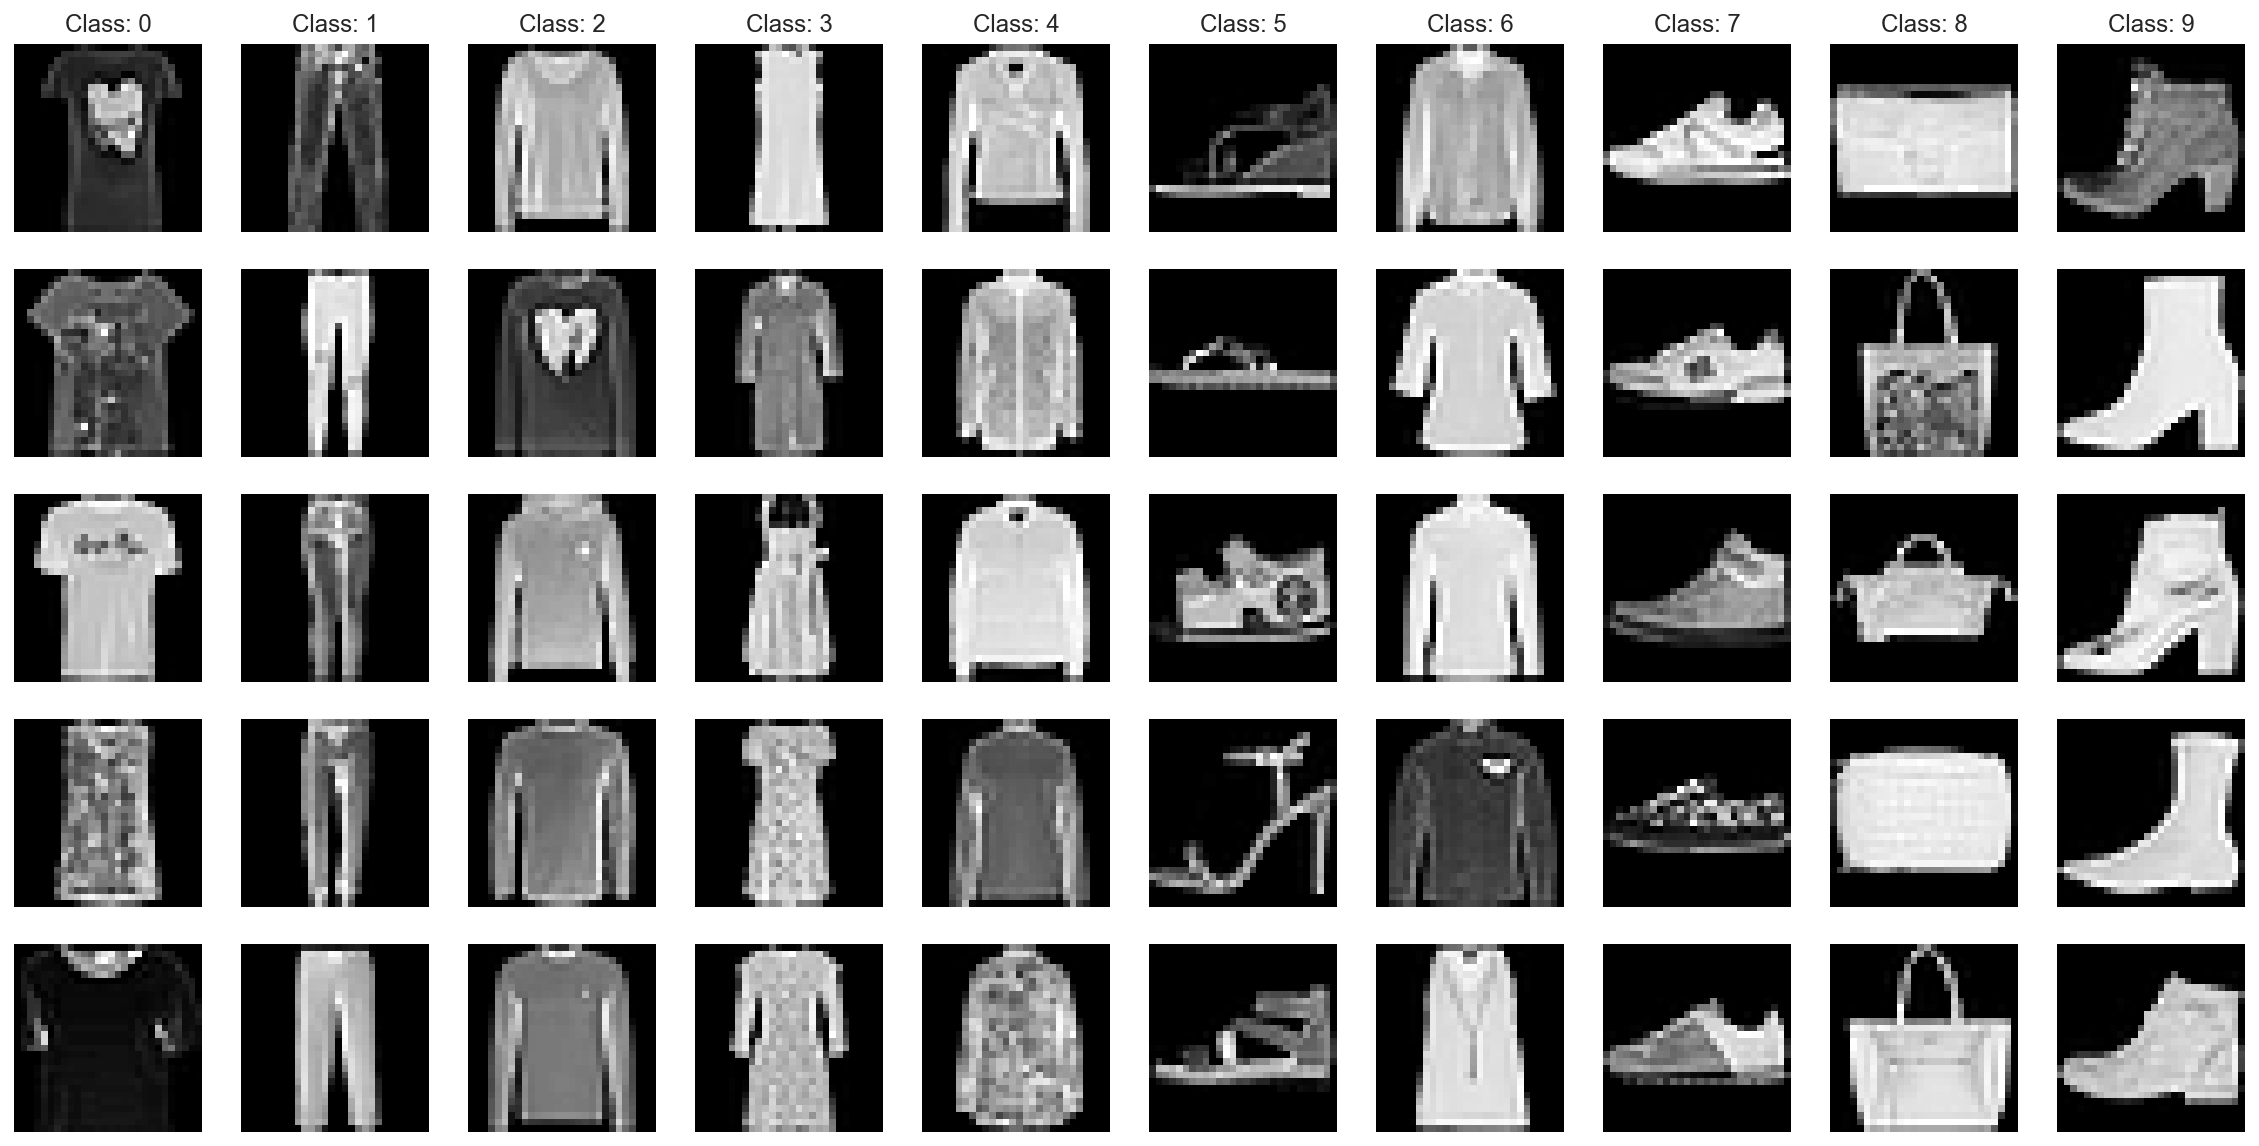

In [7]:
num_samples_per_class = 5
num_class = 10
fig,axs = plt.subplots(nrows=num_samples_per_class,ncols=num_class,figsize=(20,10))

for class_idx in range(num_class):
    X_class = X_train[y_train==class_idx].reshape(-1,28,28)
    choose = np.random.choice(range(len(X_class)),num_samples_per_class,replace=False)
    X_sample = X_class[choose]
    for sample_idx in range(num_samples_per_class):
        axs[sample_idx,class_idx].imshow(X_sample[sample_idx],cmap='gray')
        axs[sample_idx,class_idx].axis('off')
        if sample_idx==0:
            axs[sample_idx,class_idx].set_title("Class: {}".format(class_idx))

plt.savefig(assets_dir+"class_sample_visualisation.png",dpi=300)
plt.show()

In [8]:
# compute mean for the training data
X_mean = np.mean(X_train,axis=0)
X_std = np.std(X_train,axis=0)

# subtract mean from the data
# X_train -= X_mean
# X_val -= X_mean
# X_test -= X_mean
# X_dev -= X_mean

# # scale the data from -1 to 1
X_train = (X_train - 0.5)/0.5 
X_val = (X_val - 0.5)/0.5 
X_test = (X_test - 0.5)/0.5 
X_dev = (X_dev - 0.5)/0.5 

# X_train = (X_train - X_mean)/X_std 
# X_val = (X_val - X_mean)/X_std
# X_test = (X_test - X_mean)/X_std 
# X_dev = (X_dev - X_mean)/X_std

# visualize data mean
plt.imshow(X_mean.reshape(28,28),cmap='gray')
plt.title('Visualizing mean of the training data')
plt.axis('off')
plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/jsingh/anaconda3/envs/cv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-863d77bcff26>", line 3, in <module>
    X_std = np.std(X_train,axis=0)
  File "<__array_function__ internals>", line 6, in std
  File "/Users/jsingh/anaconda3/envs/cv/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 3381, in std
    **kwargs)
  File "/Users/jsingh/anaconda3/envs/cv/lib/python3.6/site-packages/numpy/core/_methods.py", line 217, in _std
    keepdims=keepdims)
  File "/Users/jsingh/anaconda3/envs/cv/lib/python3.6/site-packages/numpy/core/_methods.py", line 193, in _var
    x = asanyarray(arr - arrmean)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/jsingh/anaconda3/envs/cv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", 

TypeError: object of type 'NoneType' has no len()

In [9]:
np.mean(X_train), np.std(X_train),np.max(X_train),np.min(X_train) 

(0.2864164229328084, 0.3531894198928801, 1.0, 0.0)

In [10]:
class Dataloader:
    def __init__(self,X,y,batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
    
    def __iter__(self):
        num_iter_per_epoch = len(self)
        idxs = np.arange(len(self.y))
        np.random.shuffle(idxs)
        for i in range(num_iter_per_epoch):
            batch_mask = idxs[i*self.batch_size:(i+1)*self.batch_size]
            data, labels = self.X[batch_mask],self.y[batch_mask]
            yield data,labels
            
    def __len__(self):
        return len(self.X)//self.batch_size

## Method

In [11]:
# xavier initialization of weights
def xavier(m,h):
    return np.sqrt(6./(m+h))*np.random.uniform(-1,1,size=(m,h))

# kaiming initialization of weights
def kaiming(m,h):
    return np.sqrt(2./m)*np.random.randn(m,h)

def xavier_v2(m,h):
    return np.sqrt(1./m)*np.random.uniform(-1,1,size=(m,h))

In [12]:
def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.
    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.
    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)
    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = x.reshape(x.shape[0], -1).dot(w) + b
    cache = (x, w, b)
    return out, cache


def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.
    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None
   
    dx = dout.dot(w.T).reshape(x.shape)
    dw = x.reshape(x.shape[0], -1).T.dot(dout)
    db = np.sum(dout, axis=0)

    return dx, dw, db


def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_forward(x):
    out = sigmoid(x)
    cache = out
    return out,cache

def sigmoid_backward(dout,cache):
    h = cache
    return dout * h * (1-h)


def tanh_forward(x):
    out = (np.exp(2*x)-1)/(np.exp(2*x)+1)
    cache = out
    return out,cache

def tanh_backward(dout,cache):
    h = cache
    return dout * (1+h) * (1-h)

In [13]:
class Model:
    def __init__(self,input_size=28*28,num_hidden=400,num_classes=10,classification=False):
        self.input_size = input_size
        self.num_hidden = num_hidden
        self.classification = classification
        self.num_out = num_classes
        self.reset()
        
    def reset(self):
        # initialize weights using Xavier init
        self.initialize_weights()
        # velocity for the momentum update rule
        self.v_w1,self.v_w2,self.v_b1,self.v_b2 = 0,0,0,0
    
    def initialize_weights(self):
        # Xavier initialization
        if self.classification:
            out_size = self.num_out
        else:
            out_size = self.input_size
            
        self.W1 = xavier_v2(self.input_size,self.num_hidden)
        self.W2 = xavier_v2(self.num_hidden,out_size)
        self.b1 = np.sqrt(1./self.input_size)*np.random.uniform(-1,1,size=(self.num_hidden))
        self.b2 = np.sqrt(1./self.num_hidden)*np.random.uniform(-1,1,size=(out_size))
    
    
    def softmax_loss(self,X,y,reg=0):
        # forward propagation 
        # (X --> h (-> h_) --> o (-> o_))
        h = X@self.W1 + self.b1
        h_ = sigmoid(h)
        out = h_@self.W2 + self.b2
        softmax_out = np.exp(out)/np.sum(np.exp(out),axis=1).reshape(-1,1)
        
        # compute loss
        loss = -np.log(softmax_out[range(out.shape[0]),y]).mean() + 0.5*reg*(np.sum(self.W1**2)
                                                                            +np.sum(self.W2**2))
        
        # back propagation
        dout = softmax_out
        dout[range(out.shape[0]),y] -= 1
        
        dW2 = h_.T @ dout/X.shape[0] + reg*self.W2
        db2 = np.mean(dout,axis=0)
        
        dh_ = dout @ self.W2.T
        dh = h_*(1-h_)*dh_
        
        dW1 = X.T @ dh/X.shape[0] + reg*self.W1
        db1 = np.mean(dh,axis=0)
        return loss,dW1,db1,dW2,db2
    
    
    def mse_loss(self,X,y,reg=0):
        # forward propagation 
        # (X --> h (-> h_) --> o (-> o_))
        
        h, cache_h = affine_forward(X,self.W1,self.b1)
        h_, cache_h_ = sigmoid_forward(h)
        
        o, cache_o = affine_forward(h_, self.W2, self.b2)
        o_, cache_o_ = tanh_forward(o)
        
        # compute loss
        loss = np.mean(np.sum((X-o_)**2,axis=-1))
        
        # backward pass
        dout = 2*(o_-X)/X.shape[0]
        dout = tanh_backward(dout,cache_o_)
        dout, dW2, db2 = affine_backward(dout,cache_o)
        
        dout = sigmoid_backward(dout,cache_h_)
        dout, dW1, db1 = affine_backward(dout,cache_h)
        
        return loss,dW1,db1,dW2,db2
    
    # stochastic gradient descent
    def sgd(self,grads,lr,momentum):
        dW1,db1,dW2,db2 = grads
        # Momentum update
        # update velocity
        self.v_w1 = momentum * self.v_w1 - lr * dW1
        self.v_w2 = momentum * self.v_w2 - lr * dW2 
        self.v_b1 = momentum * self.v_b1 - lr * db1 
        self.v_b2 = momentum * self.v_b2 - lr * db2 

        # update position
        self.W1 += self.v_w1
        self.W2 += self.v_w2
        self.b1 += self.v_b1
        self.b2 += self.v_b2
    
    def train(self,X_train,y_train,X_val,y_val,num_epochs=1,batch_size=64,lr=1e-3,reg=0,classification=False,
                    momentum=0,decay=0.1,decay_points=[20,50,80],log_interval=200,verbose=True):
        results = []
        for epoch in range(num_epochs):
            train_dataloader = Dataloader(X_train,y_train,batch_size)
            for batch_idx,(data,labels) in enumerate(train_dataloader):
                if not self.classification:
                    loss,dW1,db1,dW2,db2 = self.mse_loss(data,labels,reg)
                else:
                    loss,dW1,db1,dW2,db2 = self.softmax_loss(data,labels,reg)
                    
                # SGD on model paramters
                self.sgd((dW1,db1,dW2,db2),lr,momentum)
                
                if batch_idx%log_interval==0 and verbose:
                    print ("Epoch: [{}/{}] \tBatch: [{}/{}] \tloss: {:.4f}".format(epoch+1,num_epochs,
                                                                batch_idx,len(train_dataloader),loss))
            # decay learning rate
            if epoch in decay_points:
                lr *= decay
                print ("\nreducing learning rate to {:.4f} ...".format(lr))
            
            # compute train, val accuracy if performing classification
            if self.classification:
                val_loss,val_acc = self.test(X_val,y_val,batch_size=100,reg=reg)
                train_loss,train_acc = self.test(X_train,y_train,batch_size=100,reg=reg)
                results.append([train_loss,val_loss,train_acc,val_acc])
                if verbose:
                    print("\ntrain_loss: {:.4f}\t val_loss: {:.4f}\t train_acc: {:.4f}\t val_acc: {:.4f}\n"
                                                        .format(train_loss,val_loss,train_acc,val_acc))
        return np.array(results)
    
    def test(self,X,y,batch_size,reg=0):
        loss,num_correct = 0,0
        test_dataloader = Dataloader(X,y,batch_size)
        for batch_idx,(data,labels) in enumerate(test_dataloader):
            loss += self.softmax_loss(data,labels,reg)[0]*batch_size
            pred = self.predict(data)
            num_correct += np.sum(pred==labels)
        acc = num_correct/(batch_size*len(test_dataloader))
        loss /= (batch_size*len(test_dataloader))
        return loss,acc
                
    def predict(self,X):
        # return reconstructed data
        if self.classification:
            h = X@self.W1 + self.b1
            h_ = sigmoid(h)
            out = h_@self.W2 + self.b2
            pred = np.argmax(out,axis=1)
            return pred
        # return classification predictions
        else:
            h, cache_h = affine_forward(X,self.W1,self.b1)
            h_, cache_h_ = sigmoid_forward(h)

            o, cache_o = affine_forward(h_, self.W2, self.b2)
            o_, cache_o_ = tanh_forward(o)
            return o_
    
    def get_hidden_features(self,X):
        if self.classification:
            h = X@self.W1 + self.b1
            h_ = sigmoid(h)
            return h_
        else:
            h, cache_h = affine_forward(X,self.W1,self.b1)
            h_, cache_h_ = sigmoid_forward(h)
            return h_

In [14]:
# train using full training data
model = Model(input_size=28*28,num_hidden=128,num_classes=10,classification=False)
prefix = 'base_model'
results = model.train(X_train,y_train,X_val,y_val,num_epochs=10,batch_size=64,lr=1e-2,reg=1e-4,
                      momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2)

# save results for comparison with best model
base_model_results = results

Epoch: [1/10] 	Batch: [0/859] 	loss: 202.6610
Epoch: [1/10] 	Batch: [400/859] 	loss: 25.8268
Epoch: [1/10] 	Batch: [800/859] 	loss: 19.9429
Epoch: [2/10] 	Batch: [0/859] 	loss: 22.9326
Epoch: [2/10] 	Batch: [400/859] 	loss: 17.9777
Epoch: [2/10] 	Batch: [800/859] 	loss: 17.5173
Epoch: [3/10] 	Batch: [0/859] 	loss: 17.0844
Epoch: [3/10] 	Batch: [400/859] 	loss: 15.7493
Epoch: [3/10] 	Batch: [800/859] 	loss: 15.3864
Epoch: [4/10] 	Batch: [0/859] 	loss: 14.3233
Epoch: [4/10] 	Batch: [400/859] 	loss: 13.7177
Epoch: [4/10] 	Batch: [800/859] 	loss: 15.5592
Epoch: [5/10] 	Batch: [0/859] 	loss: 13.8576
Epoch: [5/10] 	Batch: [400/859] 	loss: 14.1455
Epoch: [5/10] 	Batch: [800/859] 	loss: 12.3697
Epoch: [6/10] 	Batch: [0/859] 	loss: 11.8376
Epoch: [6/10] 	Batch: [400/859] 	loss: 12.3829
Epoch: [6/10] 	Batch: [800/859] 	loss: 15.4659
Epoch: [7/10] 	Batch: [0/859] 	loss: 11.4436
Epoch: [7/10] 	Batch: [400/859] 	loss: 10.5219
Epoch: [7/10] 	Batch: [800/859] 	loss: 10.6152
Epoch: [8/10] 	Batch: [0/8

## Testing Model

In [16]:
def visualize(X,title=''):
    mean, std = 0.5, 0.5
    X = std*X + mean
    X = X.reshape(-1,28,28)
    X = X[:16]
    
    fig,axs = plt.subplots(nrows=4,ncols=4,figsize=(5,6))
    for i in range(4):
        for j in range(4):
            ax = axs[i,j]
            ax.imshow(X[4*i+j],cmap='gray')
            ax.axis(False)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [17]:
test_loader = Dataloader(X_train,y_train,16)

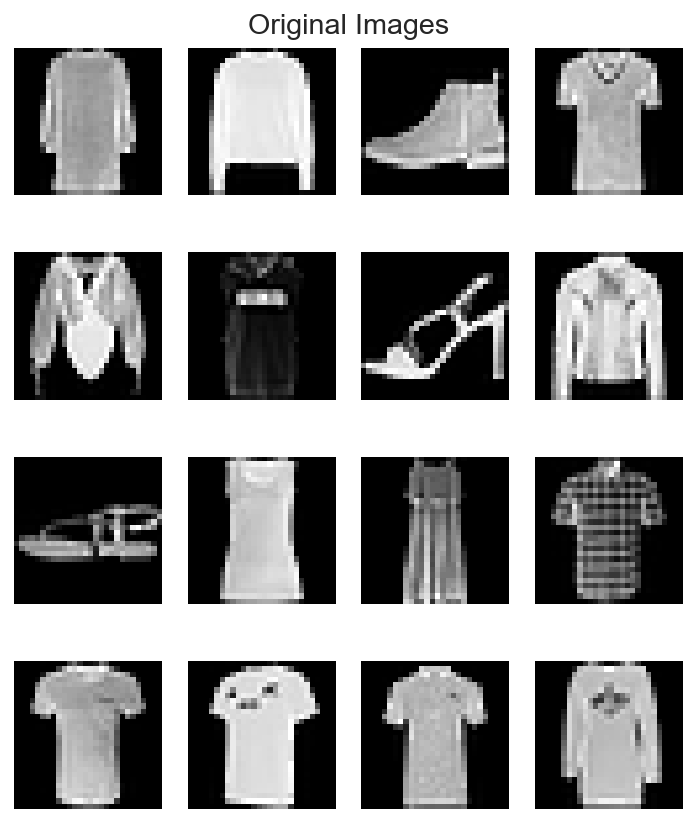

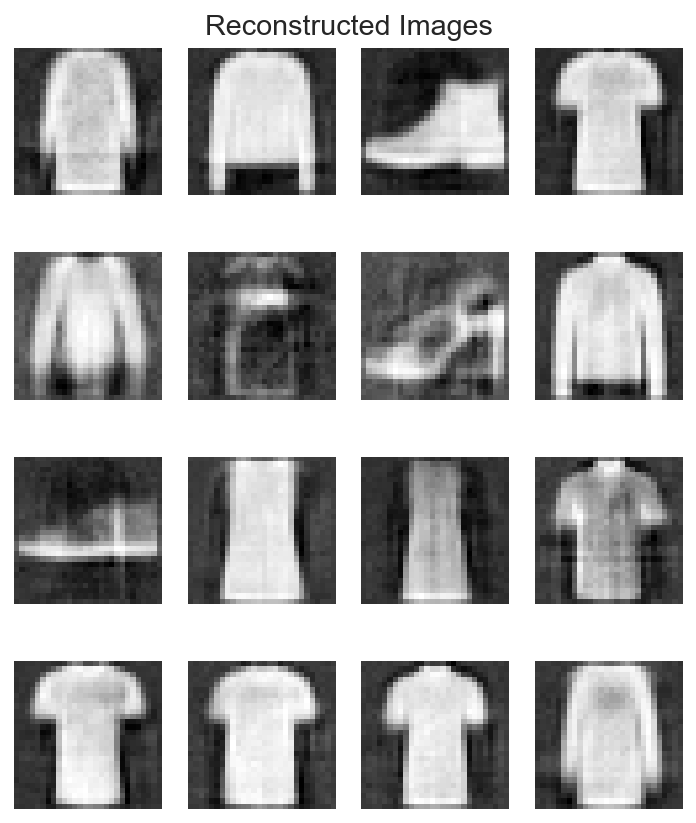

In [18]:
data = next(iter(test_loader))[0]

# visualize original data
visualize(data,'Original Images')

# visualize reconstructed output
visualize(model.predict(data),'Reconstructed Images')

## Evaluation 1: Reconstruction Error

In [18]:
# plot reconstruction error vs hidden size
num_epochs=10
error_log = []
hidden_size_list = [4,8,16,64,128,256]

for hidden_size in hidden_size_list:
    model = Model(num_hidden=hidden_size)
    prefix = 'base_model'
    results = model.train(X_train,y_train,X_val,y_val,num_epochs=num_epochs,batch_size=64,lr=1e-2,reg=1e-4,
                          momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=False)
    # compute reconstruction loss on test data
    X_test_pred = model.predict(X_test)
    error_log.append(np.mean(np.sum((X_test-X_test_pred)**2,axis=-1)))    

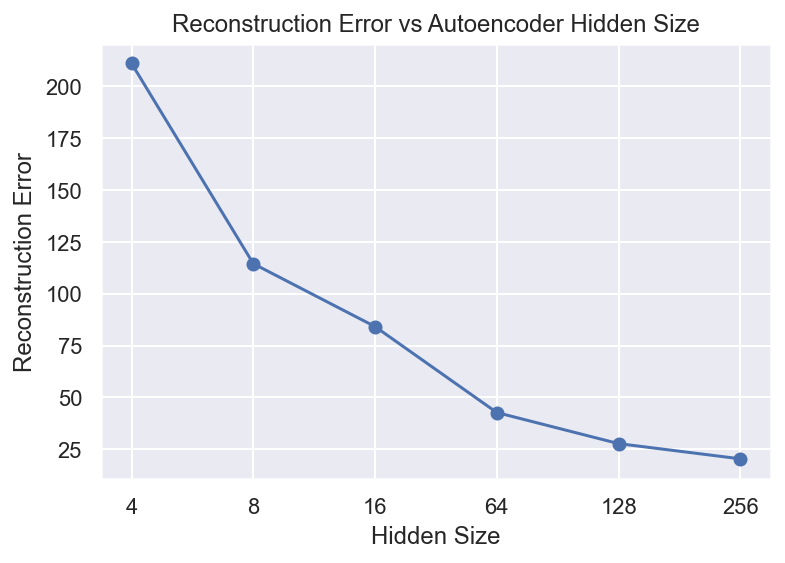

In [50]:
plt.plot(error_log,'-o')
plt.xticks(range(len(error_log)),hidden_size_list)
plt.xlabel('Hidden Size')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs Autoencoder Hidden Size')
plt.show()

## Evaluation 2: Classification Error

In [22]:
def get_reconstruction_error(X_in, X_pred):
    """
    Get reconstruction error given original data and reconstructed output
    """
    error = np.mean(np.sum((X_in-X_pred)**2,axis=-1))
    return error


def get_classification_error(X_reduced_train,y_train,X_reduced_val,y_val,X_reduced_test,y_test):
    # train a classification model on reduced data
    cls_model = Model(input_size=model.num_hidden,num_hidden=128,num_classes=10,classification=True)
    prefix = 'eval_cls_model'
    results = cls_model.train(X_reduced_train,y_train,X_reduced_val,y_val,num_epochs=10,batch_size=64,lr=1e-2,reg=1e-4,
                          momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=False)

    # test on test datase
    test_loss,test_acc = cls_model.test(X_reduced_test,y_test,batch_size=100)
    return test_acc


def get_compression_efficiency():
    pass

In [46]:
# extract reduced dimension data
X_reduced_train = model.get_hidden_features(X_train)
X_reduced_val = model.get_hidden_features(X_val)
X_reduced_test = model.get_hidden_features(X_test)

In [48]:
X_reduced_train.shape, X_reduced_val.shape, X_reduced_test.shape, 

((55000, 128), (5000, 128), (10000, 128))

In [53]:
# plot classification acc on reduced dimension data vs hidden size
num_epochs=10
error_log = []
cls_acc_log = []
hidden_size_list = [4,8,16,64,128,256]

for hidden_size in hidden_size_list:
    model = Model(num_hidden=hidden_size)
    prefix = 'base_model'
    results = model.train(X_train,y_train,X_val,y_val,num_epochs=num_epochs,batch_size=64,lr=1e-2,reg=1e-4,
                          momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=False)
    # compute reconstruction loss on test data
    X_test_pred = model.predict(X_test)
    error_log.append(np.mean(np.sum((X_test-X_test_pred)**2,axis=-1)))
    
    # extract reduced dimension data
    X_reduced_train = model.get_hidden_features(X_train)
    X_reduced_val = model.get_hidden_features(X_val)
    X_reduced_test = model.get_hidden_features(X_test)
    
    # train a classification model on reduced data
    cls_model = Model(input_size=model.num_hidden,num_hidden=128,num_classes=10,classification=True)
    prefix = 'eval_cls_model'
    results = cls_model.train(X_reduced_train,y_train,X_reduced_val,y_val,num_epochs=10,batch_size=64,lr=1e-2,reg=1e-4,
                          momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=False)

    # test on test datase
    test_loss,test_acc = cls_model.test(X_reduced_test,y_test,batch_size=100)
    cls_acc_log.append(test_acc)

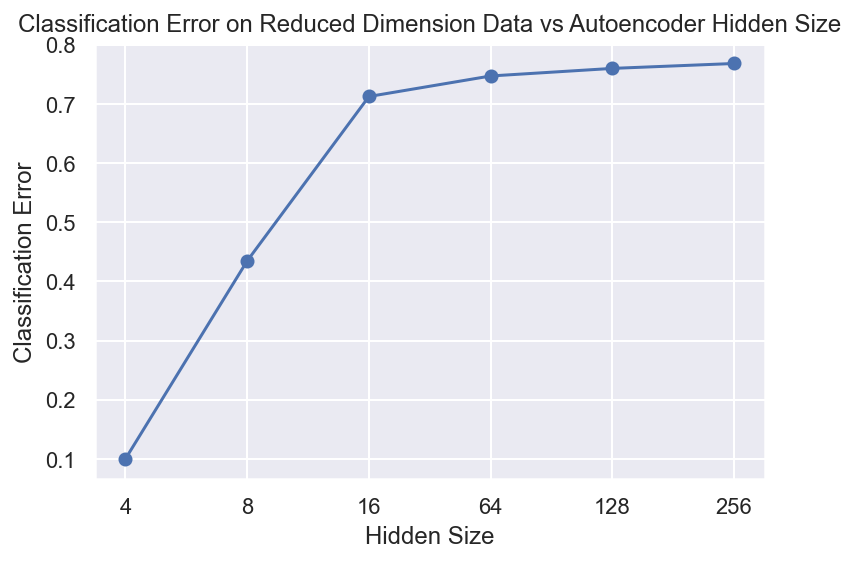

In [55]:
plt.plot(cls_acc_log,'-o')
plt.xticks(range(len(cls_acc_log )),hidden_size_list)
plt.xlabel('Hidden Size')
plt.ylabel('Classification Error')
plt.title('Classification Error on Reduced Dimension Data vs Autoencoder Hidden Size')
plt.show()

## Evaluation 3: Compression Efficiency

In [23]:
thresh_acc = 0.75
hidden_up = 128
hidden_low = 4
acc_up = 1
acc_low = 0

num_epochs=10
hidden_size = hidden_size_prev = 4
hidden_thresh = 4

while hidden_up - hidden_low > hidden_thresh:
    hidden_size = int((hidden_up + hidden_low)/2)
    model = Model(input_size=28*28,num_hidden=hidden_size,num_classes=10,classification=False)
    prefix = 'base_model'
    results = model.train(X_train,y_train,X_val,y_val,num_epochs=num_epochs,batch_size=64,lr=1e-2,reg=1e-4,
                          momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=False)
    
    # extract reduced dimension data
    X_reduced_train = model.get_hidden_features(X_train)
    X_reduced_val = model.get_hidden_features(X_val)
    X_reduced_test = model.get_hidden_features(X_test)
    
    test_acc = get_classification_error(X_reduced_train,y_train,X_reduced_val,y_val,X_reduced_test,y_test)
    print ("Search stats: ", hidden_up,hidden_low,hidden_size,test_acc)
    
    if test_acc < thresh_acc:
        hidden_low = int((hidden_up + hidden_low)/2)
    else:
        hidden_up = int((hidden_up + hidden_low)/2)
        
# get final accuracy
hidden_size = int((hidden_up + hidden_low)/2)
model = Model(input_size=28*28,num_hidden=hidden_size,num_classes=10,classification=False)
prefix = 'base_model'
results = model.train(X_train,y_train,X_val,y_val,num_epochs=num_epochs,batch_size=64,lr=1e-2,reg=1e-4,
                      momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=False)
# extract reduced dimension data
X_reduced_train = model.get_hidden_features(X_train)
X_reduced_val = model.get_hidden_features(X_val)
X_reduced_test = model.get_hidden_features(X_test)

test_acc = get_classification_error(X_reduced_train,y_train,X_reduced_val,y_val,X_reduced_test,y_test)
print ("Final hidden size: {}\t Test accuracy: {:.2f}%\t Threshold accuracy: {:.2f}%".format(hidden_size,100*test_acc,100*thresh_acc))
input_size = X_test.shape[1]
print ("Compression efficiency: {:.2f}%".format(100 - 100*hidden_size/input_size))

Search stats:  128 4 66 0.7225
Search stats:  128 66 97 0.7239
Search stats:  128 97 112 0.7311
Search stats:  128 112 120 0.7259
Search stats:  128 120 124 0.7248


NameError: name 'error_log' is not defined

In [24]:
# extract reduced dimension data
X_reduced_train = model.get_hidden_features(X_train)
X_reduced_val = model.get_hidden_features(X_val)
X_reduced_test = model.get_hidden_features(X_test)

test_acc = get_classification_error(X_reduced_train,y_train,X_reduced_val,y_val,X_reduced_test,y_test)
print ("Final hidden size: {}\t Test accuracy: {:.2f}%\t Threshold accuracy: {:.2f}%".format(hidden_size,100*test_acc,100*thresh_acc))
input_size = X_test.shape[1]
print ("Compression efficiency: {:.2f}%".format(100 - 100*hidden_size/input_size))

Final hidden size: 126	 Test accuracy: 72.76%	 Threshold accuracy: 75.00%
Compression efficiency: 83.93%


## Convenience Function

In [15]:
def get_reduced_dimension_data(X_in,reduced_dimension=32, X_train=None):
    # normalize data before feeding to neural network (assuming X is not normalized before)
    X_train = (X_train-0.5)/0.5
    X_in = (X_in-0.5)/0.5
    
    # train using full training data
    model = Model(input_size=X_train.shape[1],num_hidden=reduced_dimension, classification=False)
    prefix = 'base_model'
    print ("training autoencoder")
    results = model.train(X_train,y_train=np.ones(X_train.shape[0],dtype=np.uint8),X_val=None,y_val=None,num_epochs=10,batch_size=64,lr=1e-2,reg=1e-4,
                          momentum=0,decay=0.3,decay_points=[30,50,80],log_interval=4e2,verbose=False)
    
    print ("getting reduced dimension data")
    # get reduced dimension data
    X_reduced = model.get_hidden_features(X_in)
    return X_reduced